<a href="https://colab.research.google.com/github/DRO-Physics/DL-and-ML-for-Medical-Physics/blob/main/DL_Segmentation_BRATS2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BRATS 2021

Neo-adjuvant chemotherapy plays the role of down-staging the tumor before surgery so that the breast can be preserved as much as possible. A pathological complete response (pathCR) implies a full downstaging of tumor to T0N0 (as good as complete curation of the tumor). The event rate of pathCR in a typical Breast Cancer cohort is 20%. However, current clinical predictors with HER2, ER and PR status only achieve an AUC of about 0.70 for pathCR prediction; it is hard to determine *a priori* which patient will benefit from Neo-adjuvant chemotherapy. If we can determine with greater accuracy which patient will not benefit from Neoadjuvant chemotherapy, time will not be wasted on the treatment and surgery can be performed earlier before tumor become more aggressive. The role of this project is to determine if Deep Learning on CT data can value-add to the current clinical predictors and enhance the AUC. 

Hong-Qi Tan



In [1]:
import os
import glob 
import shutil
import json
import h5py
import nibabel as nib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from datetime import datetime

import tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.callbacks import LambdaCallback, CSVLogger
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

import tensorflow as tf
import util

## for tensorboard
# %load_ext tensorboard

ModuleNotFoundError: ignored

In [ ]:
## Check tf and keras version
print(tf.keras.__version__)
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)



2.4.0
2.4.0


In [ ]:
!nvidia-smi

Fri Jul 16 11:00:34 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 460.27.04    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:3B:00.0  On |                  N/A |
| 27%   29C    P8    15W / 250W |    777MiB / 11016MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:AF:00.0 Off |                  N/A |
| 27%   

In [ ]:
## Data Generator
# import importlib
# importlib.reload(DataGenerator)
from DataGenerator import DataGenerator

BASE_DIR = 'RSNA_ASNR_MICCAI_BraTS2021_TrainingData/'
folders = glob.glob(BASE_DIR+'BraTS*')

partition = {}
partition['train'] = [os.path.split(folders[k])[1] for k in range(len(folders)) if k<1000]
partition['valid'] = [os.path.split(folders[k])[1] for k in range(len(folders)) if k>=1000]

# Parameters
params = {'dim': (240,240,16),
          'batch_size': 2,
          'n_classes': 3,
          'n_channels': 4,
          'shuffle': True}

# Generators
# training_generator = DataGenerator(partition['train'], **params)
# validation_generator = DataGenerator(partition['valid'], **params)
# print(training_generator)


Using TensorFlow backend.


In [ ]:
## Load Json
DIR_TRAIN = 'train_folder/'
DIR_VALID = 'valid_folder/'

with open('config.json') as f:
    config = json.load(f)
    
# config['train'] = config['train'][0:100]
# config['valid'] = config['valid'][0:100]
         
## Load Generator
def training_generator(): 
    for ID in config['train']: 
        with h5py.File(DIR_TRAIN + ID, 'r') as f:
                x = np.array(f.get("x"))
                y = np.array(f.get("y"))
        yield x, y
    
def validation_generator(): 
    for ID in config['valid']: 
        with h5py.File(DIR_VALID + ID, 'r') as f:
                x = np.array(f.get("x"))
                y = np.array(f.get("y"))
        yield x, y


In [ ]:
## Data Augmentation
from scipy import ndimage

@tf.function
def image_augmentation(image):
    def scipy_rotate(image):
        ## Add Noise
#         print(np.shape(image))
        # define some rotation angles
        angle = np.random.uniform(-10,10)
        # rotate volume
        volume = ndimage.rotate(image, angle, reshape=False)
#         volume = volume + np.random.normal(0, 0.005)
        # volume[volume < 0] = 0
        # volume[volume > 1] = 1 ## Only use this if using min-max normalization
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [image], tf.float32)
#     label = tf.one_hot(label, num_classes)
    return augmented_volume

def train_preprocessing(volume, label):
    volume = image_augmentation(volume)
    volume = tf.expand_dims(volume, axis = 0) ## 3 for channel last
    return (volume, label)

def valid_preprocessing(volume, label):
    volume = tf.expand_dims(volume, axis = 0) ## 3 for channel last
    return (volume, label)


In [ ]:
## Define tf dataset
train_loader = tf.data.Dataset.from_generator(training_generator, (tf.float32, tf.float32))
validation_loader = tf.data.Dataset.from_generator(validation_generator,(tf.float32, tf.float32))
ds = train_loader.batch(10)

train_dataset = train_loader.shuffle(len(partition['train']))
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
# train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(2, drop_remainder=True).prefetch(8)

valid_dataset = validation_loader.shuffle(len(partition['valid']))
valid_dataset = valid_dataset.apply(tf.data.experimental.ignore_errors())
# valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(2, drop_remainder=True).prefetch(8)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 128, 128, 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 32, 128, 128, 3488        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 128, 128, 0           conv3d[0][0]                     
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 64, 128, 128, 55360       activation[0][0]                 
______________________________________________________________________________________________

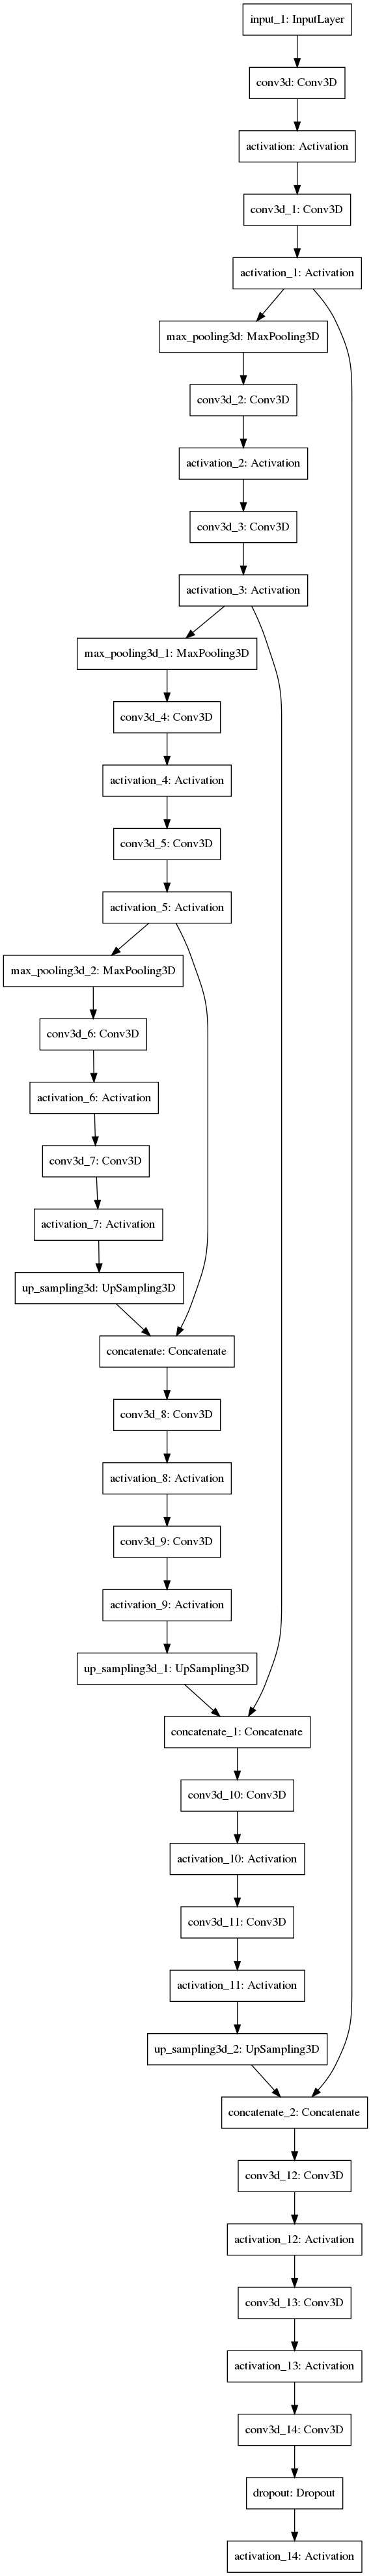

In [ ]:
### This is the first attempt of training a DL model from scratch. 
## Defining Model
from  tensorflow.keras import backend as K
K.set_image_data_format('channels_first')

model = util.unet_model_3d(loss_function=util.weighted_bce_dice_loss, metrics=[util.dice_coefficient])
model.summary()
plot_model(model, to_file='MyModel.png')

In [ ]:
## Defining Checkpoints and Callbacks!
# Save the best weight!
checkpoint = ModelCheckpoint('./checkpoints/best_dice.h5', monitor='val_dice_coefficient', verbose=1, save_best_only=True, mode='max')

## Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=5,verbose=0,mode='auto')
## CSV Logger
csv = CSVLogger('training_stats.csv', separator=',', append=False)
## LR schedular
reduce_LR = ReduceLROnPlateau(monitor='val_loss',factor = 0.9, patience=3,cooldown=0, min_lr = 0.00001)

## Tensorboard
logdir = "logs/image/" + datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the basic TensorBoard callback for logging the scalars etc
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)



In [ ]:
## Train the Model
epochs = 50
learning_rate = 0.001

# model = tf.keras.models.load_model('saved_model/Model_v1',  custom_objects={'soft_dice_loss': util.soft_dice_loss,'dice_coefficient':util.dice_coefficient})
# model.compile(loss=model.loss, optimizer=model.optimizer, metrics=[util.dice_coefficient])
K.set_value(model.optimizer.lr, 0.001)

history = model.fit(x=train_dataset,
                    validation_data=valid_dataset, 
                    epochs = epochs,
                    shuffle=True,
                    batch_size = 4,
                    callbacks = [csv, reduce_LR, early_stopping, checkpoint])

Epoch 1/50
1000/1000 [==============================] - 561s 496ms/step - loss: 0.7701 - dice_coefficient: 0.2182 - val_loss: 0.3919 - val_dice_coefficient: 0.5058

Epoch 00001: val_dice_coefficient improved from -inf to 0.50583, saving model to ./checkpoints/best_dice.h5
Epoch 2/50
1000/1000 [==============================] - 565s 498ms/step - loss: 0.7610 - dice_coefficient: 0.2209 - val_loss: 0.3588 - val_dice_coefficient: 0.5659

Epoch 00002: val_dice_coefficient improved from 0.50583 to 0.56587, saving model to ./checkpoints/best_dice.h5
Epoch 3/50
1000/1000 [==============================] - 570s 505ms/step - loss: 0.7595 - dice_coefficient: 0.2217 - val_loss: 0.3828 - val_dice_coefficient: 0.5320

Epoch 00003: val_dice_coefficient did not improve from 0.56587
Epoch 4/50
1000/1000 [==============================] - 567s 499ms/step - loss: 0.7552 - dice_coefficient: 0.2228 - val_loss: 0.3586 - val_dice_coefficient: 0.5459

Epoch 00004: val_dice_coefficient did not improve from 0.5

In [ ]:
history.history

{'loss': [0.8093498349189758,
  0.9338750243186951,
  0.9341250061988831,
  0.9287499785423279,
  0.9318125247955322,
  0.9319999814033508,
  0.937125027179718,
  0.9280624985694885,
  0.9354375004768372],
 'dice_coefficient': [0.17319825291633606,
  0.06612502038478851,
  0.06587502360343933,
  0.07125001400709152,
  0.06818751245737076,
  0.06800001859664917,
  0.06287501752376556,
  0.07193751633167267,
  0.06456251442432404],
 'val_loss': [0.9512500166893005,
  0.9259999990463257,
  0.9282500147819519,
  0.9202499985694885,
  0.9309999942779541,
  0.9292500019073486,
  0.9340000152587891,
  0.921999990940094,
  0.9457499980926514],
 'val_dice_coefficient': [0.04875003919005394,
  0.0740000382065773,
  0.07175004482269287,
  0.07975006103515625,
  0.06900005042552948,
  0.07075002044439316,
  0.06600002944469452,
  0.0780000388622284,
  0.05425003170967102],
 'lr': [0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.001,
  0.00090000004,
  0.00090000004]}

In [ ]:
model.save('Model_v1.')

INFO:tensorflow:Assets written to: Model_v1./assets


In [ ]:
## Start tensorboard
%tensorboard --logdir logs/image 

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  import sys


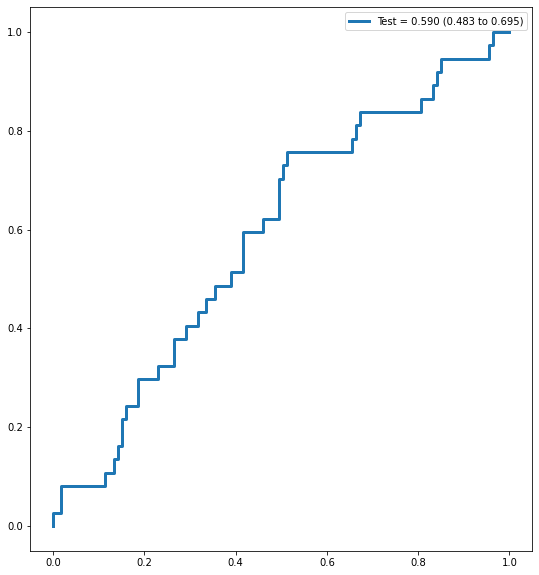

In [ ]:
### Apply prediction
import stat_util
from sklearn.metrics import roc_auc_score, roc_curve, auc, brier_score_loss

model.load_weights("./checkpoints/best_weights_auc.h5")
test_pred = []
for k in range(len(y_test)): 
    pred = model.predict(np.expand_dims(np.expand_dims(x_test[k],axis=0),axis=0))[0][0]
    test_pred.append(pred)
#     print(pred)

np.savetxt('Prob_train_pred.txt', test_pred)
# np.savetxt('Target_test.txt', y_test)
# print(y_test, test_pred)
plot_ROC(y_test, test_pred, 'Test')



In [ ]:
def plot_ROC(y_actual, y_prob, label_set):
    ## Configure bootstrap
    mean_score, ci_lower, ci_upper, scores = stat_util.score_stat_ci(y_actual, y_prob, score_fun=roc_auc_score, stat_fun=np.mean)
    fpr, tpr, _ = roc_curve(y_actual, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(0, figsize=(9,10))
    plt.plot(fpr, tpr, color=None, Linewidth=3, label = '{} = {:0.3f} ({:0.3f} to {:0.3f})'.format(label_set, roc_auc, ci_lower, ci_upper))
    plt.legend()

In [ ]:
## This function is to visualize the class activation map. It is adapted from https://keras.io/api/metrics/classification_metrics/#auc-class
## and modified to be compatible with our 3d images

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, classifier_layer_names):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = Model(classifier_input, x)
    print(np.shape(img_array))

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]
        print(top_class_channel)

#     # This is the gradient of the top predicted class with regard to
#     # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 2, 3, 4))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[i, :, :, :] *= pooled_grads[i]

#     # The channel-wise mean of the resulting feature map
#     # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=0)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
import matplotlib.cm as cm

index = 58
## Run Gradcam
image = np.expand_dims(np.expand_dims(x_test[index],axis=0),axis=0)
# print(image)
heatmap = make_gradcam_heatmap(image, model,'depth_7_relu', ['global_average_pooling3d', 'dense', 'dense_1'])
print(y_test[index])
## Load Image again
img = x_test[index]


(1, 1, 128, 128, 64)
tf.Tensor([0.98295605], shape=(1,), dtype=float32)
1


In [ ]:
from ipywidgets import interact
import ipywidgets as widgets

def PlotHeatmap(x): 
    width, height, depth = np.shape(img)
    heatmap_slice = zoom(heatmap, zoom = (width*1.0 / 16, (height*1.0 / 16), (depth*1.0) / 8 ))
    plt.imshow(np.transpose(img[:,:,x]), cmap='bone')
    plt.imshow(np.transpose(heatmap_slice[:,:,x]), cmap='jet', alpha = 0.4)
    plt.savefig('Patient4.png')
    plt.show()
    


In [ ]:
interact(PlotHeatmap, x=widgets.IntSlider(min=0, max=63, step=2, value=18))

interactive(children=(IntSlider(value=18, description='x', max=63, step=2), Output()), _dom_classes=('widget-i…

<function __main__.PlotHeatmap(x)>